In [1]:
import sys
import os
import random
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt

from bgm import *
from sagan import *
from causal_model import *
from load_data import *

In [2]:
root_folder = 'dataset/celebA/'
img_dim = 64
batch_size = 128
causal_diagram = 'smiling'

if causal_diagram == 'smiling':
    #saved_folder = 'saved_model_downsample_smile_reduce_latent_dim'
    #saved_folder = 'saved_model_downsample_smile'
    saved_folder = 'saved_model_downsample_smile_increase_latent_dim'
    cols = ['Smiling', 'Male', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Narrow_Eyes', 'Chubby']
    num_label = len(cols)
    A = torch.zeros((num_label, num_label))
    A[0, 2:6] = 1
    A[1, 4] = 1
elif causal_diagram == 'attractive':
    saved_folder = 'saved_model_attractive'
    cols = ['Young', 'Male', 'Bags_Under_Eyes', 'Chubby', 'Heavy_Makeup', 'Receding_Hairline', 'Gray_Hair']
    num_label = len(cols)
    A = torch.zeros((num_label, num_label))
    A[0, 2:7] = 1
    A[1, 4] = 1
    A[1, 5] = 1
    
    
test_dataloader = get_dataloader(root_folder,'dear_test', img_dim=img_dim, 
                                    batch_size=batch_size, cols = cols)    

In [3]:
in_channels = 3
fc_size = 2048

#latent_dim = 10
#latent_dim = 100
latent_dim = 150


g_conv_dim = 32
enc_dist='gaussian'
enc_arch='resnet'
enc_fc_size=2048
enc_noise_dim=128
dec_dist = 'implicit'
prior = 'linscm'

In [4]:
model = BGM(latent_dim, g_conv_dim, img_dim,
                enc_dist, enc_arch, enc_fc_size, enc_noise_dim, dec_dist,
                prior, num_label, A)
model = nn.DataParallel(model)

In [5]:
checkpoint = torch.load(f'{saved_folder}/bgm', map_location='cpu')
print(checkpoint['epoch'])

165


In [6]:
model.load_state_dict(checkpoint['model_state_dict'])
model = model.module.to('cpu')

In [7]:
def plot_image(fake, c=10, r=None, ):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))
        r = 1 if r is None else r
        _,ax = plt.subplots(r, c, figsize=(24,3*r))
        if r == 1:
            for i in range(10):
                ax[i].imshow(fake[i])
                ax[i].set_xticks([])
                ax[i].set_yticks([])
        else:
            for i in range(r):
                ax[i][0].set_ylabel(cols[i])
                for j in range(c):
                    ax[i][j].imshow(fake[i*c+j])
                    ax[i][j].set_xticks([])
                    ax[i][j].set_yticks([])
                    
        plt.show()

Reconstruct


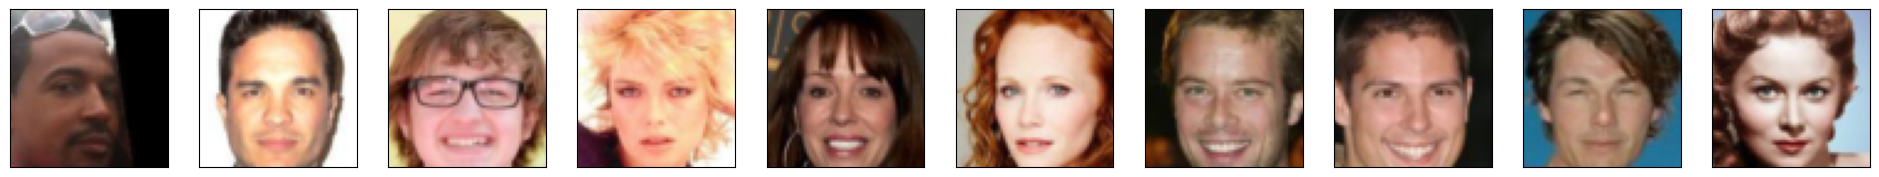

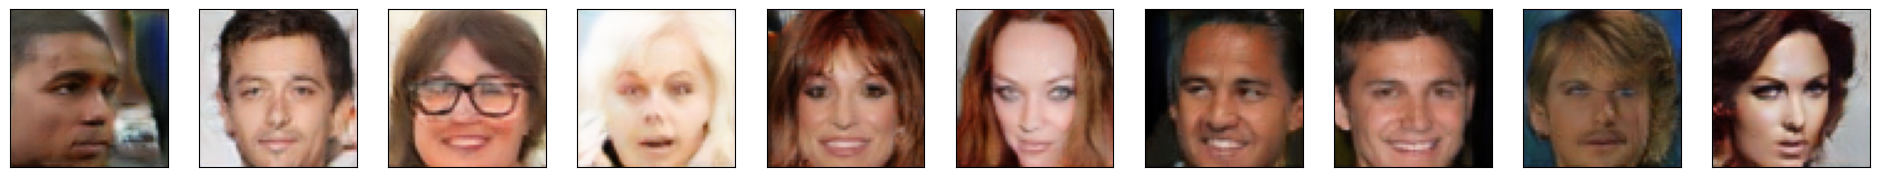

tensor([[-19.9525,  20.1194,  -5.6564,  -3.7264,  -2.3696,  -0.3649],
        [ -6.0817,  -6.9898,  -9.9011,  -3.1937,  -0.6918,  -7.5954],
        [  0.9976,   5.9877,   4.2222,  13.0476, -11.7129, -16.3184],
        [ -9.6058,   1.4112,  -7.2061,  -6.6004,   5.0105,  -4.8368],
        [ 23.9599,   3.4065,  15.8923,   6.1774,   0.4121,   2.5125],
        [  2.6775,  -7.1603,   6.1062,   2.2316,  -9.0513, -14.3154],
        [  5.0108,   6.1981,   0.3042,   9.6088,  -8.4350,  -5.8643],
        [ 12.6694,  14.1256,   1.9313,  -0.3023,  -0.7263,  -1.5399],
        [ -0.8726,   2.2708,  -3.4308,   1.5840,   3.4646,  -7.1853],
        [ -4.3034, -25.0795,  -4.3438,  -4.1344, -18.2360, -12.3335]])
tensor([[0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1.

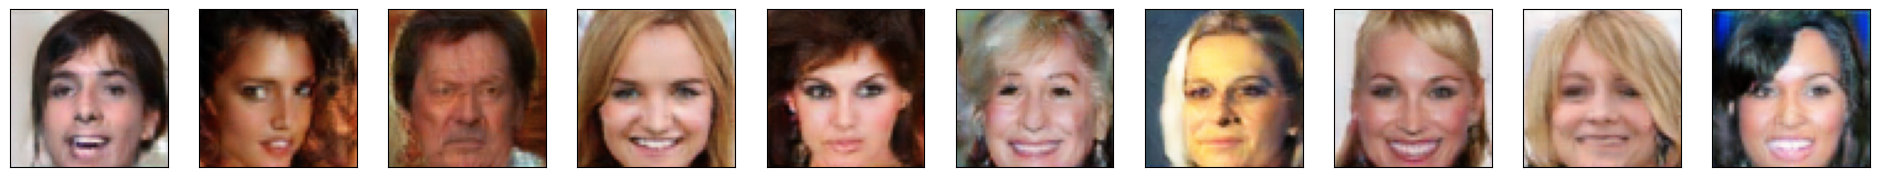

In [8]:
t = 10
for batch_idx, (x, label) in enumerate(test_dataloader):
    with torch.no_grad():
        x = x.to('cpu')
        x_ = x[:t]
        x_recon = model(x_, recon=True)
        x_recon = (x_recon * 0.5) + 0.5
        print('Reconstruct')
        plot_image(x_*0.5 + 0.5)
        plot_image(x_recon)
        feat = model.prior(model(x)[:t, :num_label])
        print(model.encode(x_)[:t, :num_label])
        print(label[:t, :])
        print(torch.round(torch.sigmoid(feat)))
        
        print('Random')
        z = torch.randn(x.size(0), latent_dim, device=x.device)
        x_fake = model(None, z)
        x_fake = x_fake * 0.5 + 0.5
        plot_image(x_fake)
        
    break

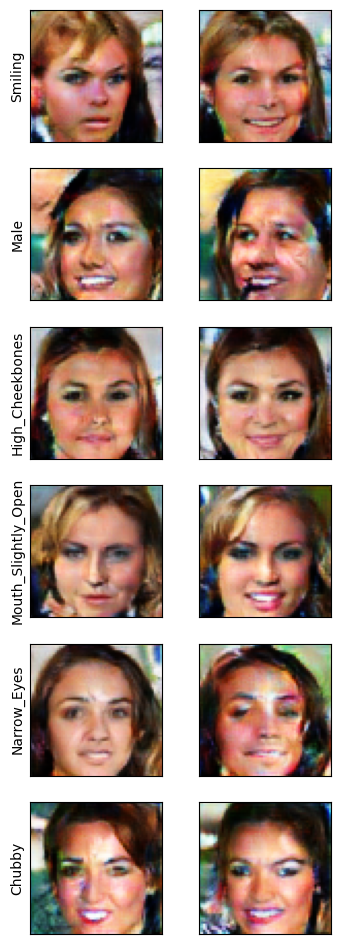

In [13]:
_, ax = plt.subplots(num_label,2, figsize=(4,12))
with torch.no_grad():
    for col_num in range(num_label):
        ax[col_num][0].set_ylabel(cols[col_num])
        eps = torch.randn(1, latent_dim, device='cpu')
        eps[:, :num_label] = torch.zeros(1, num_label, device='cpu')
        for i in range(2):   
            label_z = model.prior(eps[:, :num_label])
            label_z[:, 1] = -30
            label_z[:, col_num] = -20 if i==0 else 20
            other_z = eps[:, num_label:]
            z = torch.cat([label_z, other_z], dim=1)
            temp = model.decoder(z)
            
            temp = np.transpose(temp.numpy(), (0, 2, 3, 1))[0]
            temp = temp*0.5 + 0.5
            ax[col_num][i].imshow(temp)
            ax[col_num][i].set_xticks([])
            ax[col_num][i].set_yticks([])

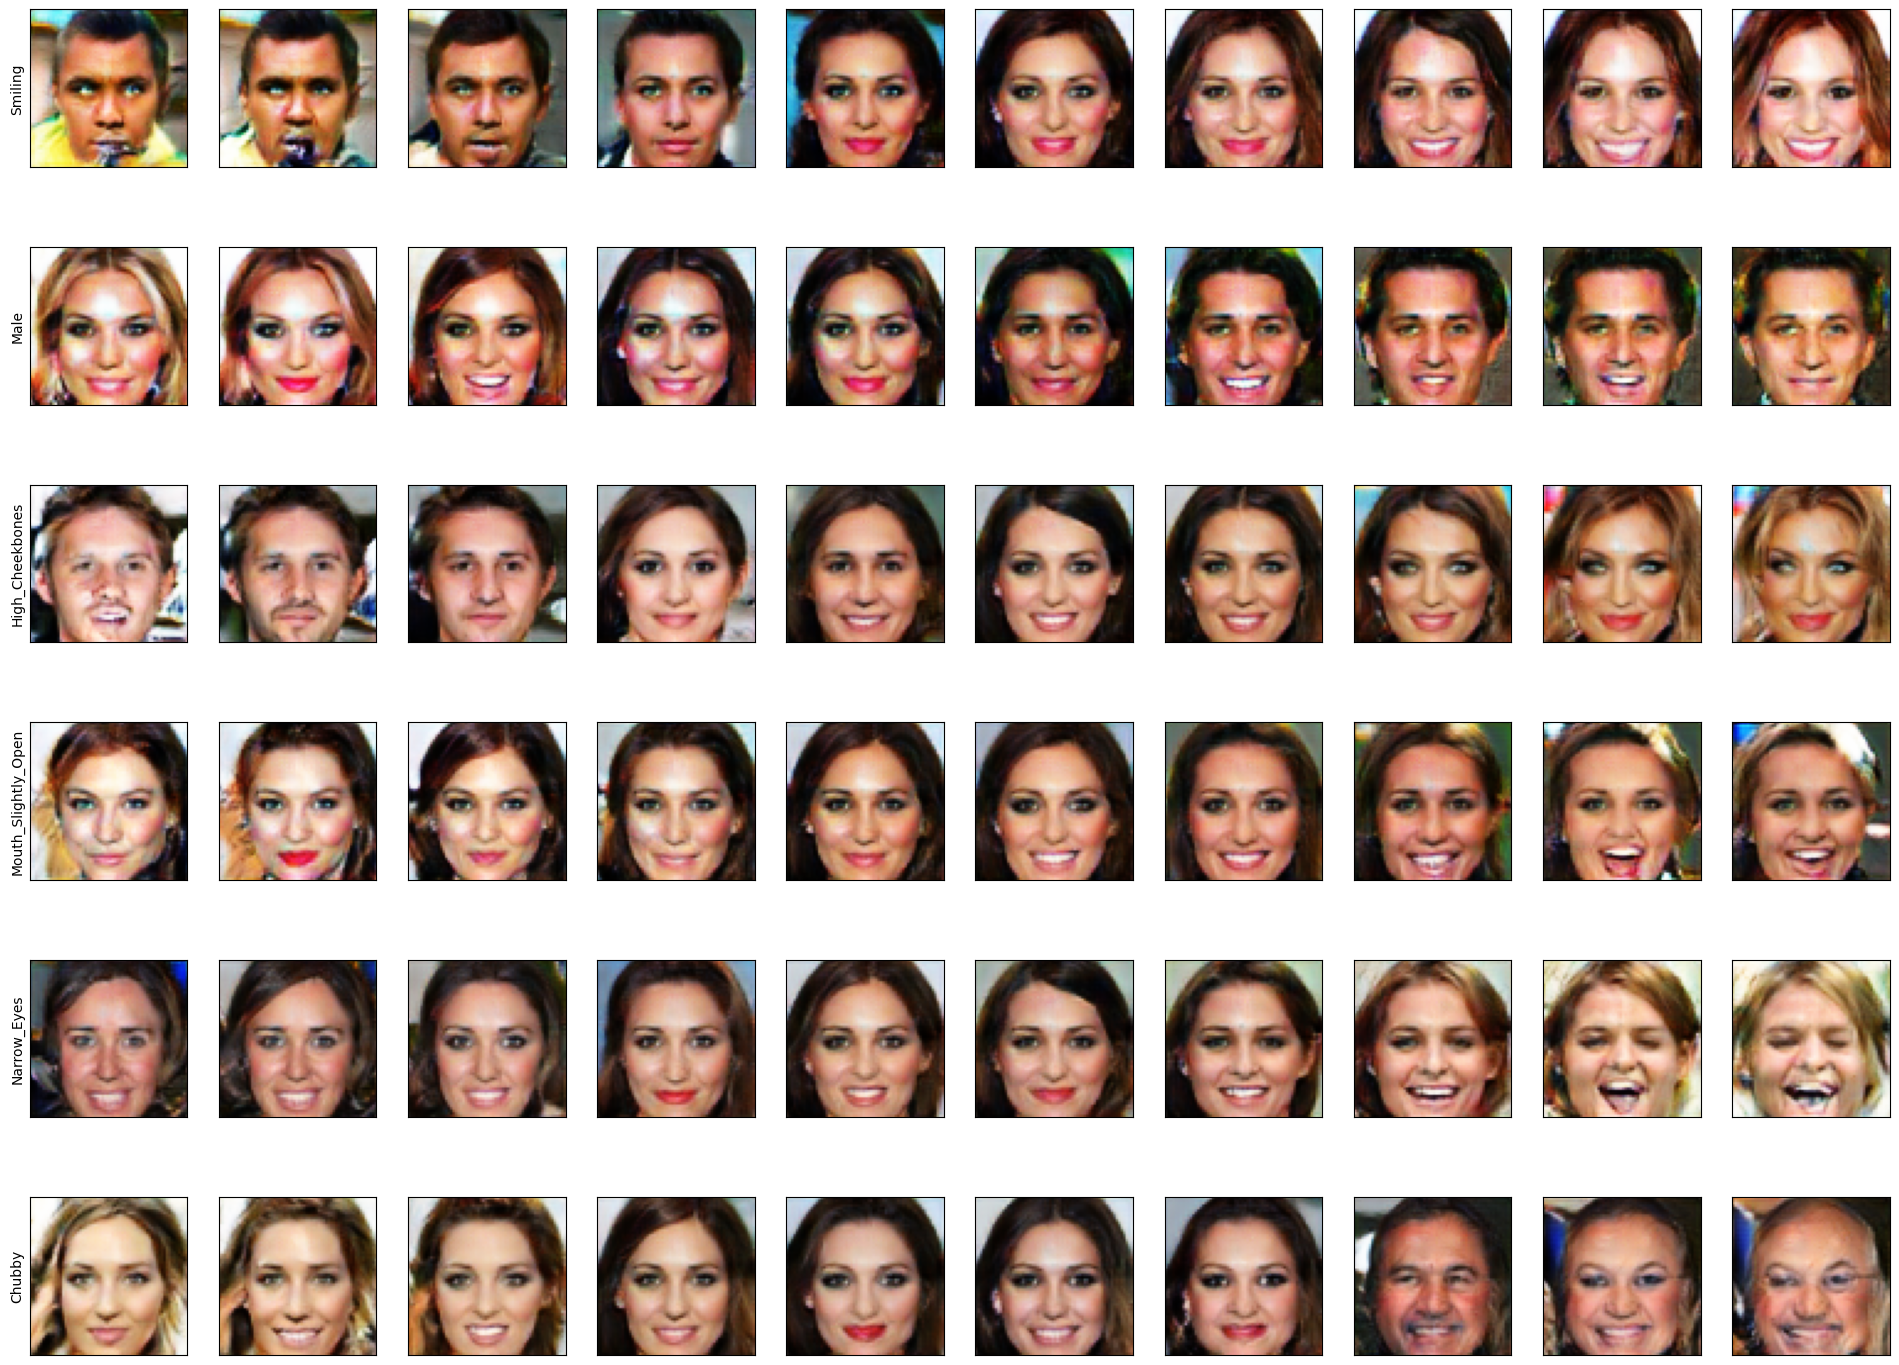

In [10]:
fixed_zeros = torch.zeros(1, latent_dim, device='cpu')
temp = model.traverse(fixed_zeros)
temp = temp * 0.5 + 0.5
plot_image(temp, r = num_label, c = 10)